# Using VGG Blocks
We can generalize the specification of a VGG-block as one or more convolutional layers with the same number of filters and a filter size of 3×3, a stride of 1×1, same padding so the output size is the same as the input size for each filter, and the use of a rectified linear activation function. These layers are then followed by a max pooling layer with a size of 2×2 and a stride of the same dimensions.

We can define a function to create a VGG-block using the Keras functional API with a given number of convolutional layers and with a given number of filters per layer.

[Transfer Learning](#https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Model
from keras.layers import Input
from keras.utils import plot_model

## Loading Dataset
We only use the Left eye dataset after some preprocessing. Used CLAHE on the images. the dataset contain high resulotion left eye only images. We will resize the images to (256, 256) for saving RAM usage as the full resulotion will exceed the limit of 12 GB.

In [3]:
# Take gpu device name for using it 
device_name = tf.test.gpu_device_name()

# Set desired image size and load dataset into corresponding variables
IMG_SIZE = (256, 256)
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/IRIS-Gender/labeled_data/Left/CLAHE/train', labels='inferred', label_mode='binary', class_names=None, 
                                             color_mode='rgb', batch_size=32, image_size= IMG_SIZE, shuffle=True)
validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/IRIS-Gender/labeled_data/Left/CLAHE/valid', labels='inferred', label_mode='binary', class_names=None,
                                                  color_mode='rgb', batch_size=32, image_size=IMG_SIZE, shuffle=True)
test_dataset = image_dataset_from_directory('/content/drive/MyDrive/IRIS-Gender/labeled_data/Left/CLAHE/test', labels='inferred', label_mode='binary', class_names=None, 
                                            color_mode='rgb', batch_size=32, image_size=IMG_SIZE, shuffle=True)

Found 1292 files belonging to 2 classes.
Found 282 files belonging to 2 classes.
Found 281 files belonging to 2 classes.


## Data preprocessing

We do some preprocessing on the dataset such as data augmentation and rescaling pixel values

In [4]:
# Configure the dataset for performence (allow next batch to be prepared while processing current batch at the cost of memory)
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Some data augmentation (as the dataset isn't that large) by random horizontal fliping
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])

# Rescale pixel values
preprocess_input = tf.keras.applications.vgg16.preprocess_input


## Create base model and feature extraction

We create the base model from the **VGG16** model. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. Hopfully this base of knowledge will help us classify eyes.

We need to pick which layer of VGG16 we will use for feature extraction. The very last classification layer (on "top") is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation ("bottleneck layer"). The bottleneck layer features retain more generality as compared to the final/top layer.

Then we freeze the convolutional base created from the previous step and to use as a feature extractor. 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

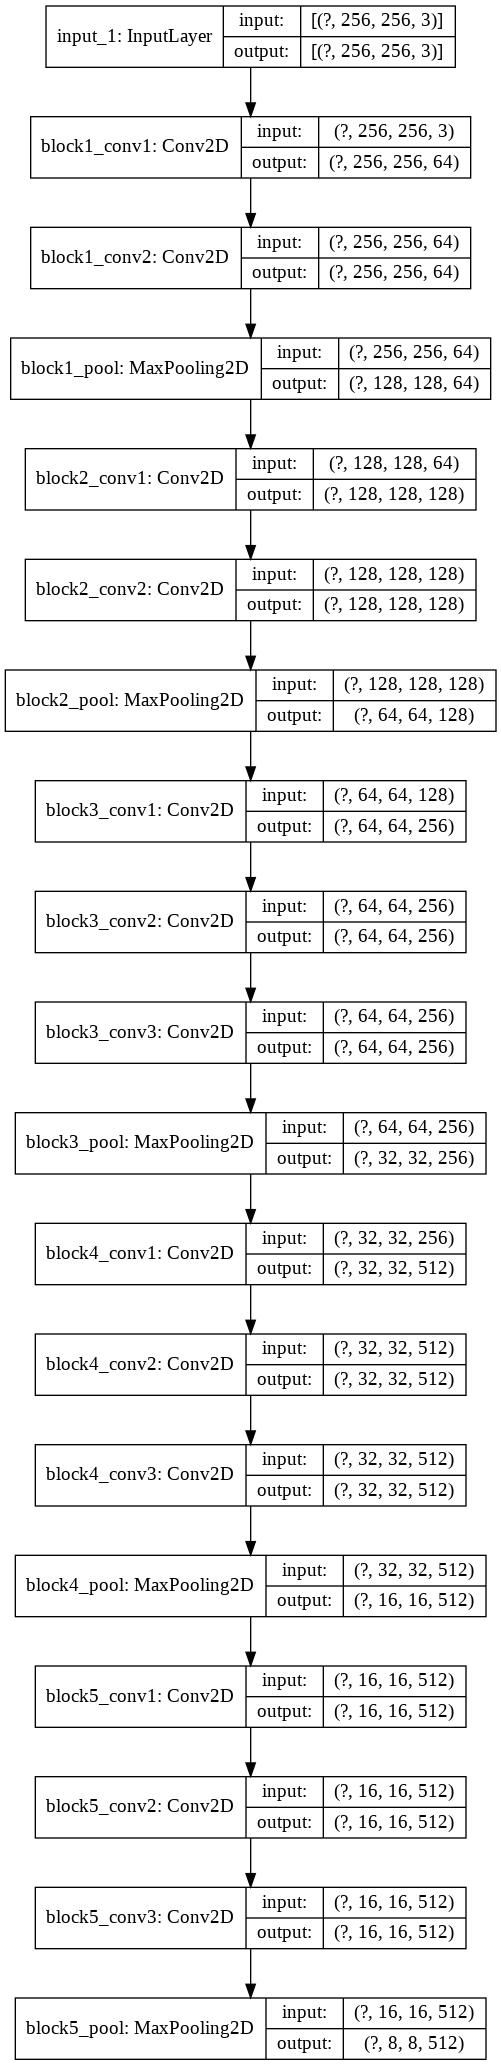

In [5]:
# Create base model from the pre-trained model VGG16  
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=IMG_SHAPE)

# Freeze the convlutional base and use it for feature extraction
base_model.trainable = False

# Summarize base model
base_model.summary()

# plot model architecture
plot_model(base_model, show_shapes=True, to_file='vgg16.png')

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a **tf.keras.layers.GlobalAveragePooling2D** layer to convert the features to a single 1280-element vector per image.

We apply a **tf.keras.layers.Dense** layer to convert these features into a single prediction per image.

In [6]:
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

WE compile the model before training it. Since there are two classes, use a binary cross-entropy loss with **from_logits=True** since the model provides a linear output.

In [7]:
# Compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='model.png')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [8]:
len(model.trainable_variables)

2

## Train the model
We tried different epochs numbers and all of them gave the same initial accuracy of 50%. The 10 epochs model had final accuracy of 97%, The 30 epochs model had a final accuracy of 95%, and the 20 epochs accuracy have a 9% as shown below.

In [9]:
# Train the model
initial_epochs = 20
with tf.device(device_name):
    loss0, accuracy0 = model.evaluate(validation_dataset)

9/9 [==============================] - 1s 138ms/step - loss: 3.0163 - accuracy: 0.5000


In [10]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.02
initial accuracy: 0.50


In [11]:
with tf.device(device_name):
    history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/20
41/41 [==============================] - 111s 3s/step - loss: 2.1758 - accuracy: 0.5170 - val_loss: 1.4897 - val_accuracy: 0.4894
Epoch 2/20
41/41 [==============================] - 111s 3s/step - loss: 1.3735 - accuracy: 0.5503 - val_loss: 1.0098 - val_accuracy: 0.5071
Epoch 3/20
41/41 [==============================] - 110s 3s/step - loss: 1.2597 - accuracy: 0.5658 - val_loss: 0.9233 - val_accuracy: 0.5177
Epoch 4/20
41/41 [==============================] - 110s 3s/step - loss: 1.1890 - accuracy: 0.5751 - val_loss: 0.8570 - val_accuracy: 0.5461
Epoch 5/20
41/41 [==============================] - 110s 3s/step - loss: 1.0858 - accuracy: 0.5859 - val_loss: 0.7963 - val_accuracy: 0.5709
Epoch 6/20
41/41 [==============================] - 109s 3s/step - loss: 1.0133 - accuracy: 0.5952 - val_loss: 0.7447 - val_accuracy: 0.5922
Epoch 7/20
41/41 [==============================] - 109s 3s/step - loss: 0.9030 - accuracy: 0.6385 - val_loss: 0.7013 - val_accuracy: 0.6206
Epoch 8/20
41

## Learning curves
The learning curves of the training and validation accuracy/loss when using the VGG16 base model as a fixed feature extractor.

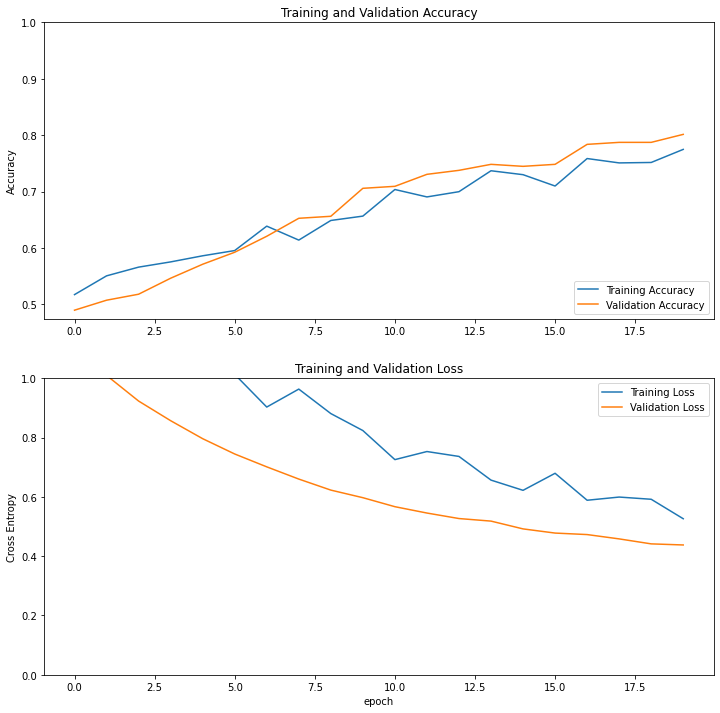

In [12]:
# Show accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
We train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added.

In [13]:
# Fine tuning
# Un-freeze top layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [14]:
# Compile again with lower learning rate (fear of overfitting)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [15]:
len(model.trainable_variables)

12

## Training after fine tuning


In [16]:
# Continue training
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

with tf.device(device_name):
    history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 20/40
41/41 [==============================] - 109s 3s/step - loss: 0.4486 - accuracy: 0.8452 - val_loss: 0.3224 - val_accuracy: 0.7979
Epoch 21/40
41/41 [==============================] - 110s 3s/step - loss: 0.1401 - accuracy: 0.9458 - val_loss: 0.3435 - val_accuracy: 0.9043
Epoch 22/40
41/41 [==============================] - 111s 3s/step - loss: 0.1057 - accuracy: 0.9667 - val_loss: 0.3337 - val_accuracy: 0.9078
Epoch 23/40
41/41 [==============================] - 111s 3s/step - loss: 0.0745 - accuracy: 0.9690 - val_loss: 0.2572 - val_accuracy: 0.9255
Epoch 24/40
41/41 [==============================] - 109s 3s/step - loss: 0.0597 - accuracy: 0.9783 - val_loss: 0.2240 - val_accuracy: 0.9326
Epoch 25/40
41/41 [==============================] - 110s 3s/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.2144 - val_accuracy: 0.9433
Epoch 26/40
41/41 [==============================] - 111s 3s/step - loss: 0.0386 - accuracy: 0.9876 - val_loss: 0.3273 - val_accuracy: 0.9255
Epoch 

## New learning curves


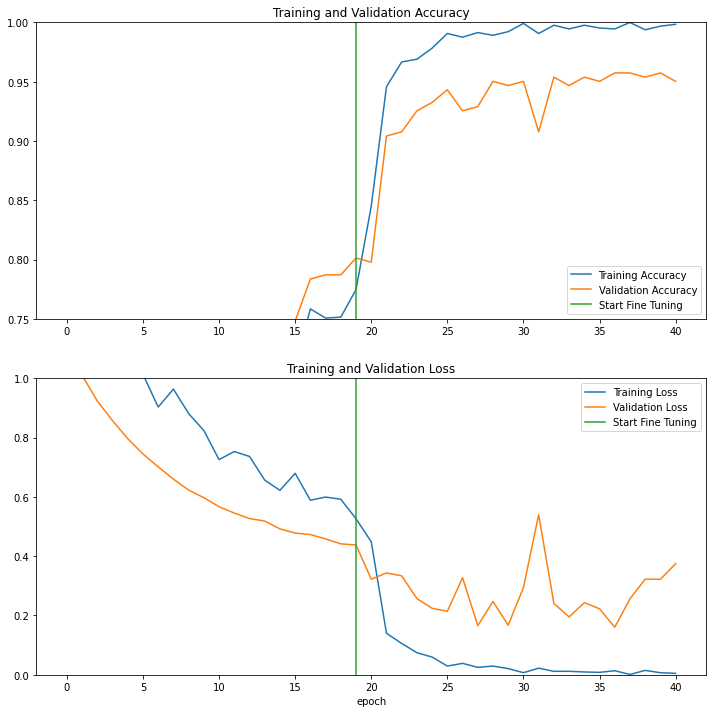

In [17]:
# new acc and loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.75, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction
Finaly we can verify the performance of the model on new data using test set.

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 1s 137ms/step - loss: 0.2438 - accuracy: 0.9573
Test accuracy : 0.9572953581809998


## Saving Model
Saving model and weights into yaml and h5

In [20]:
# Serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml","w") as yaml_file:
    yaml_file.write(model_yaml)
# Serialize weights to HDF5
model.save_weights('model.h5')